# Model Evaluation and Interpretability

This notebook focuses on the final evaluation of the selected XGBoost model.  
We analyze the most influential features using SHAP and simulate how the model could operate in a production environment.

In [39]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath(".."))
from src.model_utils import load_model, load_scaler
from src.data_loader import load_processed_data

from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

## Load validation data and trained model


In [10]:
val_df = load_processed_data(split="val")
X_val = val_df.drop(columns=["Class"])
y_val = val_df["Class"]

model = load_model()
scaler = load_scaler()

## SHAP

We use SHAP (SHapley Additive exPlanations) to interpret the internal behavior of the model.  
This technique allows us to visualize how each feature contributes to each individual prediction.

For better interpretability, we restore the original scale of the `Amount` feature in a copy of the validation set.  
This copy is used exclusively for SHAP plots and does not affect the actual model inputs.


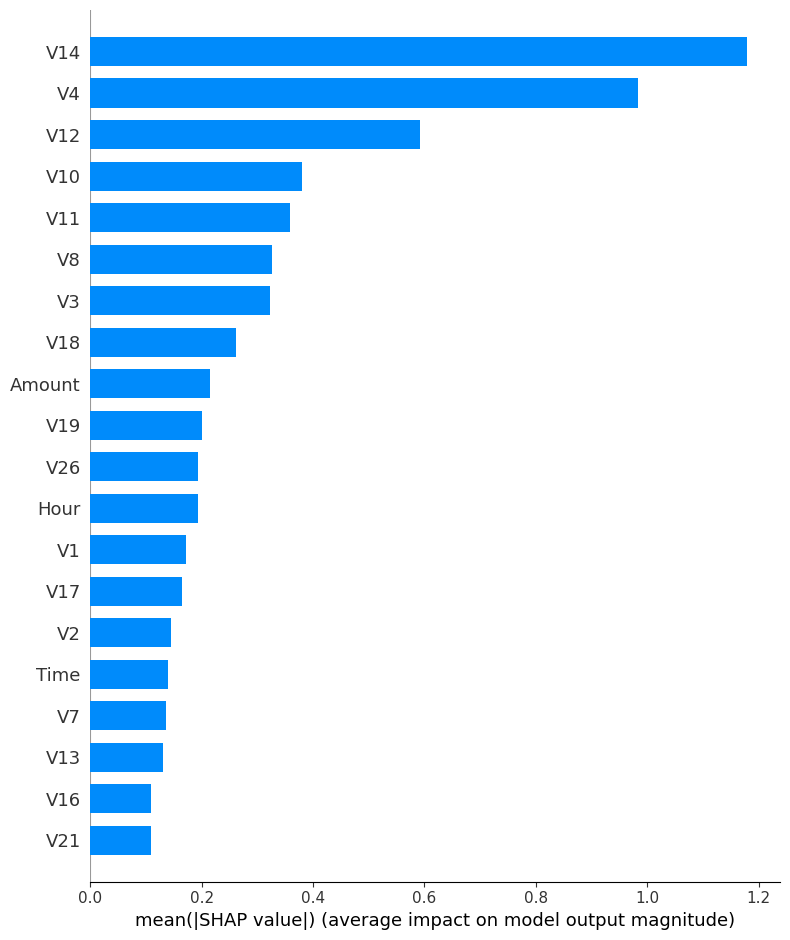

In [11]:
X_val_shap = X_val.copy()
X_val_shap["Amount"] = scaler.inverse_transform(X_val[["Amount"]])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val_shap, plot_type="bar")

### SHAP Summary Analysis

The SHAP bar plot highlights the most influential features used by the XGBoost model:

- **`V14` and `V4`** are the most impactful, strongly influencing fraud detection.
- **`V12`, `V10`, and `V11`** also contribute significantly, aligning with earlier EDA insights.
- **`Amount`**, while not in the top 5, shows relevant influence.
- **Time-based features** (`Hour`, `Time`) have lower average impact but still contribute.
- Other variables (e.g., `V21`, `V16`, `V13`) appear with minimal effect individually.

This confirms the model relies heavily on specific PCA components, while `Amount` and temporal features offer secondary signals.

## Predicting New Transactions

To simulate how the model would operate in a production environment, we define a function that receives a new transaction as input and returns both the predicted class and its probability.

The same preprocessing applied during training is used here to ensure consistency.

In [30]:
def predict_new_transaction(input_data: dict, model, scaler, threshold=0.8):
    """
    Simulates a production-like prediction using the trained model and scaler.

    Parameters:
        input_data (dict): Dictionary with the same feature names as X_val
        model: Trained model object
        scaler: Fitted scaler for the 'Amount' feature
        threshold (float): Probability threshold for classification

    Returns:
        dict: Prediction result including probability and binary class
    """
    df = pd.DataFrame([input_data])

    # Create Hour feature
    df["Hour"] = (df["Time"] // 3600) % 24

    # Scale Amount
    df["Amount"] = scaler.transform(df[["Amount"]])

    # Create engineered features
    df["Amount_to_mean_ratio"] = df["Amount"] / X_val["Amount"].mean()
    df["Amount_to_std_ratio"] = (df["Amount"] - X_val["Amount"].mean()) / X_val["Amount"].std()

    # Predict
    proba = model.predict_proba(df)[:, 1][0]
    prediction = int(proba > threshold)

    return {"probability": round(float(proba),5), "prediction": prediction}


## Testing the Simulation

We take a random transaction from the validation set and simulate its prediction as if it were a real-time input coming into the system.

In [31]:
sample = X_val.sample(n=1, random_state=7).iloc[0]
sample_dict = sample.to_dict()

result = predict_new_transaction(sample_dict, model, scaler)
print("Prediction result:", result)

Prediction result: {'probability': 0.03519, 'prediction': 0}


## Final Evaluation on Test Set

The test set is used only once, at the very end of the project, to provide an unbiased estimate of the model's performance on completely unseen data.

We apply the same preprocessing steps to the test data, generate predictions using the final model, and evaluate the results using standard classification metrics.

In [32]:
# Load test set
test_df = load_processed_data(split="test")
X_test = test_df.drop(columns=["Class"])
y_test = test_df["Class"]

# Create Hour feature
X_test["Hour"] = (X_test["Time"] // 3600) % 24

# Scale Amount
X_test["Amount"] = scaler.transform(X_test[["Amount"]])

# Create engineered features
X_test["Amount_to_mean_ratio"] = X_test["Amount"] / X_val["Amount"].mean()
X_test["Amount_to_std_ratio"] = (X_test["Amount"] - X_val["Amount"].mean()) / X_val["Amount"].std()

# Predict probabilities and apply threshold
y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test > 0.8).astype(int)


Classification Report (Test Set - Threshold 0.8):

              precision    recall  f1-score   support

           0     0.9998    0.9988    0.9993     28432
           1     0.5526    0.8571    0.6720        49

    accuracy                         0.9986     28481
   macro avg     0.7762    0.9280    0.8356     28481
weighted avg     0.9990    0.9986    0.9987     28481



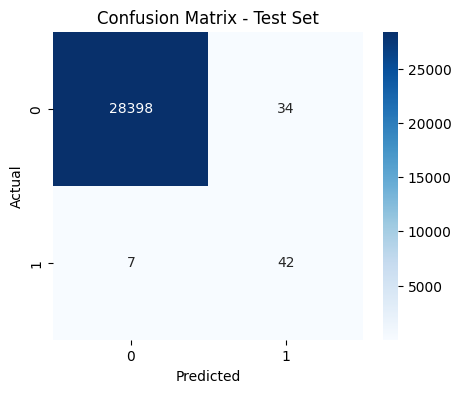

In [33]:
print("Classification Report (Test Set - Threshold 0.8):\n")
print(classification_report(y_test, y_pred_test, digits=4))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

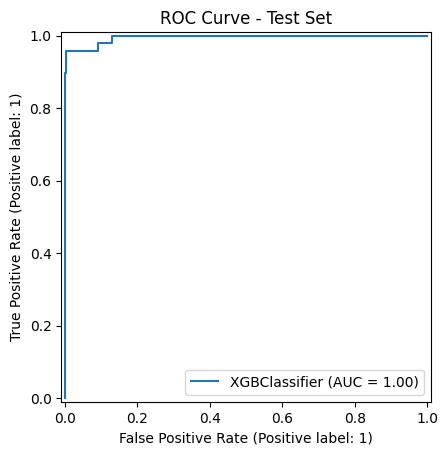

In [36]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve - Test Set")
plt.show()

### Final Evaluation on Test Set

The final XGBoost model was evaluated using the test set to simulate real-world performance. The chosen decision threshold of **0.8** was applied to prioritize reducing false positives while maintaining high recall.

**Key metrics:**

- **Recall (fraud class - 1):** 0.8571 → indicates strong ability to catch fraudulent transactions.
- **Precision (fraud class - 1):** 0.5526 → reflects a tolerable trade-off: more false positives, but still informative.
- **AUC-ROC:** 1.00 → demonstrates excellent separation capability between classes.
- **Confusion matrix:** 42 out of 49 fraud cases correctly identified, with only 7 missed.
- **Accuracy:** 99.86% → consistent with previous validation results.

These results validate the model's generalization and support its deployment in a real-time fraud detection pipeline.

## Saving Evaluation Results

To ensure traceability and allow external usage of the model's final performance, we save the main evaluation metrics and the confusion matrix to a `.json` file.

This file summarizes the model’s performance on the test set and can be used for reporting, auditing, or monitoring purposes.


In [43]:
os.makedirs("results", exist_ok=True)
results = {
    "precision": precision_score(y_test, y_pred_test),
    "recall": recall_score(y_test, y_pred_test),
    "f1_score": f1_score(y_test, y_pred_test),
    "accuracy": accuracy_score(y_test, y_pred_test),
    "auc_roc": roc_auc_score(y_test, y_proba_test),
    "confusion_matrix": cm.tolist()
}

with open("../results/test_results.json", "w") as f:
    json.dump(results, f, indent=4)


## Final Considerations

This notebook completed the final evaluation of our fraud detection model using XGBoost.

We interpreted the model’s predictions using SHAP, simulated real-time predictions with a production-ready function,  
and evaluated the final model on the test set — a holdout dataset never seen during training or validation.

The model demonstrated high recall and strong AUC-ROC performance, supporting its suitability for real-world deployment.  